# GAN2

In [203]:
import numpy as np
import matplotlib.pyplot as plt
#  to read image from url
from imageio import imread
# to display image
from PIL import Image
import torch
import torch.nn.functional as F
import torch.nn as nn
import pandas as pd
import torchvision
import torchvision.transforms as T # provides all the transformations of images
from torch.utils.data import DataLoader, Dataset,Subset
from sklearn.model_selection import train_test_split

In [204]:
transform = T.Compose(
    [
    T.ToTensor(),
    T.Lambda(lambda x: x.view(-1)) # Flatten to [784]
]
)
dataset = torchvision.datasets.FashionMNIST(root='../data',train=True,download=False,transform=transform)

In [205]:
item,label = dataset[0]
item ,label

(tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0000, 0.0000,
         0.0510, 0.2863, 0.0000, 0.0000, 0.0039, 0.0157, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0039, 0.0

In [206]:
dataset.class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [207]:
dataset.data.shape , dataset.targets.shape

(torch.Size([60000, 28, 28]), torch.Size([60000]))

In [208]:
dataIndices = [idx for idx,item in enumerate(dataset) if (item[1] == 1 or item[1] == 2 or item[1] == 7)]
len(dataIndices)

18000

In [209]:
data = Subset(dataset,dataIndices)

In [210]:
batch_size = 18000
loader = DataLoader(data,batch_size=batch_size,shuffle=True,drop_last=True)

In [211]:
class discriminatorNetwork(nn.Module):
    def __init__(self):
        super().__init__()

        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 256)
        self.out = nn.Linear(256, 1)
        
    def forward(self, x):
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = self.out(x)
        return torch.sigmoid(x)
    
    
class generatorNetwork(nn.Module):
    def __init__(self):
        super().__init__()

        self.fc1 = nn.Linear(64, 256)
        self.fc2 = nn.Linear(256, 256)
        self.out = nn.Linear(256, 784)
        
    def forward(self, x):
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = torch.tanh(self.out(x))
        return x    

In [212]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
device

device(type='mps')

In [213]:
lossFun = nn.BCELoss()

dnet = discriminatorNetwork().to(device)
gnet = generatorNetwork().to(device)

d_optimizer = torch.optim.Adam(dnet.parameters(), lr=0.0003)
g_optimizer = torch.optim.Adam(gnet.parameters(), lr=0.0003)

In [214]:
import torch
import numpy as np

def trainGan(dnet, gnet, lossFun, d_optimizer, g_optimizer, num_epochs, loader, device):
    losses = np.zeros((num_epochs, 2))
    descDecision = np.zeros((num_epochs, 2))

    for epoch in range(num_epochs):
        epoch_d_loss = 0
        epoch_g_loss = 0
        d_acc_real = 0
        d_acc_fake = 0
        num_batches = 0

        for real_data, _ in loader:
            batch_size = real_data.size(0)
            real_data = real_data.to(device)

            # Generate fake data
            noise = torch.randn(batch_size, 64).to(device)
            fake_data = gnet(noise)

            # Labels
            real_labels = torch.ones(batch_size, 1).to(device)
            fake_labels = torch.zeros(batch_size, 1).to(device)

            # ----- Train Discriminator -----
            pred_real = dnet(real_data)
            pred_fake = dnet(fake_data.detach())

            d_loss_real = lossFun(pred_real, real_labels)
            d_loss_fake = lossFun(pred_fake, fake_labels)
            d_loss = d_loss_real + d_loss_fake

            d_optimizer.zero_grad()
            d_loss.backward()
            d_optimizer.step()

            # Discriminator accuracy on real and fake
            d_acc_real += torch.mean((pred_real > 0.5).float()).item()
            d_acc_fake += torch.mean((pred_fake < 0.5).float()).item()
            epoch_d_loss += d_loss.item()

            # ----- Train Generator -----
            noise = torch.randn(batch_size, 64).to(device)
            fake_data = gnet(noise)
            pred_fake = dnet(fake_data)

            g_loss = lossFun(pred_fake, real_labels)  # Want discriminator to think fakes are real

            g_optimizer.zero_grad()
            g_loss.backward()
            g_optimizer.step()

            epoch_g_loss += g_loss.item()
            num_batches += 1

        # Store average loss and discriminator accuracy for this epoch
        losses[epoch, 0] = epoch_d_loss / num_batches
        losses[epoch, 1] = epoch_g_loss / num_batches
        descDecision[epoch, 0] = d_acc_real / num_batches
        descDecision[epoch, 1] = d_acc_fake / num_batches

        print(f"Epoch {epoch+1}/{num_epochs} | D Loss: {losses[epoch, 0]:.4f} | G Loss: {losses[epoch, 1]:.4f} | D Acc Real: {descDecision[epoch, 0]:.2f} | D Acc Fake: {descDecision[epoch, 1]:.2f}")

    return losses, descDecision

In [ ]:
losses, descDecision = trainGan(dnet, gnet, lossFun, d_optimizer, g_optimizer, 500, loader,device)

Epoch 1/500 | D Loss: 1.3686 | G Loss: 0.6906 | D Acc Real: 1.00 | D Acc Fake: 0.00
Epoch 2/500 | D Loss: 1.3192 | G Loss: 0.6895 | D Acc Real: 1.00 | D Acc Fake: 0.00
Epoch 3/500 | D Loss: 1.2759 | G Loss: 0.6881 | D Acc Real: 1.00 | D Acc Fake: 0.00
Epoch 4/500 | D Loss: 1.2356 | G Loss: 0.6862 | D Acc Real: 1.00 | D Acc Fake: 0.00
Epoch 5/500 | D Loss: 1.1968 | G Loss: 0.6836 | D Acc Real: 1.00 | D Acc Fake: 0.00
Epoch 6/500 | D Loss: 1.1592 | G Loss: 0.6796 | D Acc Real: 1.00 | D Acc Fake: 0.00
Epoch 7/500 | D Loss: 1.1234 | G Loss: 0.6740 | D Acc Real: 1.00 | D Acc Fake: 0.00
Epoch 8/500 | D Loss: 1.0908 | G Loss: 0.6661 | D Acc Real: 1.00 | D Acc Fake: 0.00
Epoch 9/500 | D Loss: 1.0634 | G Loss: 0.6556 | D Acc Real: 1.00 | D Acc Fake: 0.00
Epoch 10/500 | D Loss: 1.0424 | G Loss: 0.6420 | D Acc Real: 1.00 | D Acc Fake: 0.00
Epoch 11/500 | D Loss: 1.0290 | G Loss: 0.6259 | D Acc Real: 1.00 | D Acc Fake: 0.00
Epoch 12/500 | D Loss: 1.0245 | G Loss: 0.6075 | D Acc Real: 1.00 | D Acc 

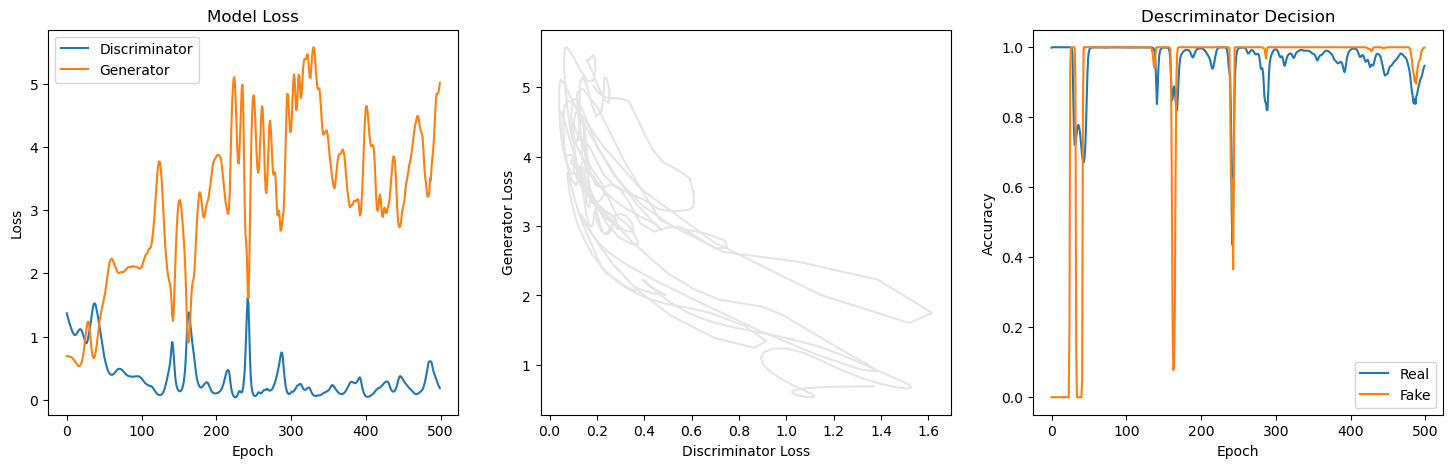

In [218]:
fig,ax = plt.subplots(1,3,figsize=(18,5))

ax[0].plot(losses)
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model Loss')
ax[0].legend(['Discriminator', 'Generator'])

ax[1].plot(losses[:,0],losses[:,1],'k',alpha=.1)
ax[1].set_xlabel('Discriminator Loss')
ax[1].set_ylabel('Generator Loss')

ax[2].plot(descDecision)
ax[2].set_xlabel('Epoch')
ax[2].set_ylabel('Accuracy')
ax[2].set_title('Descriminator Decision')
ax[2].legend(['Real', 'Fake'])

plt.show()


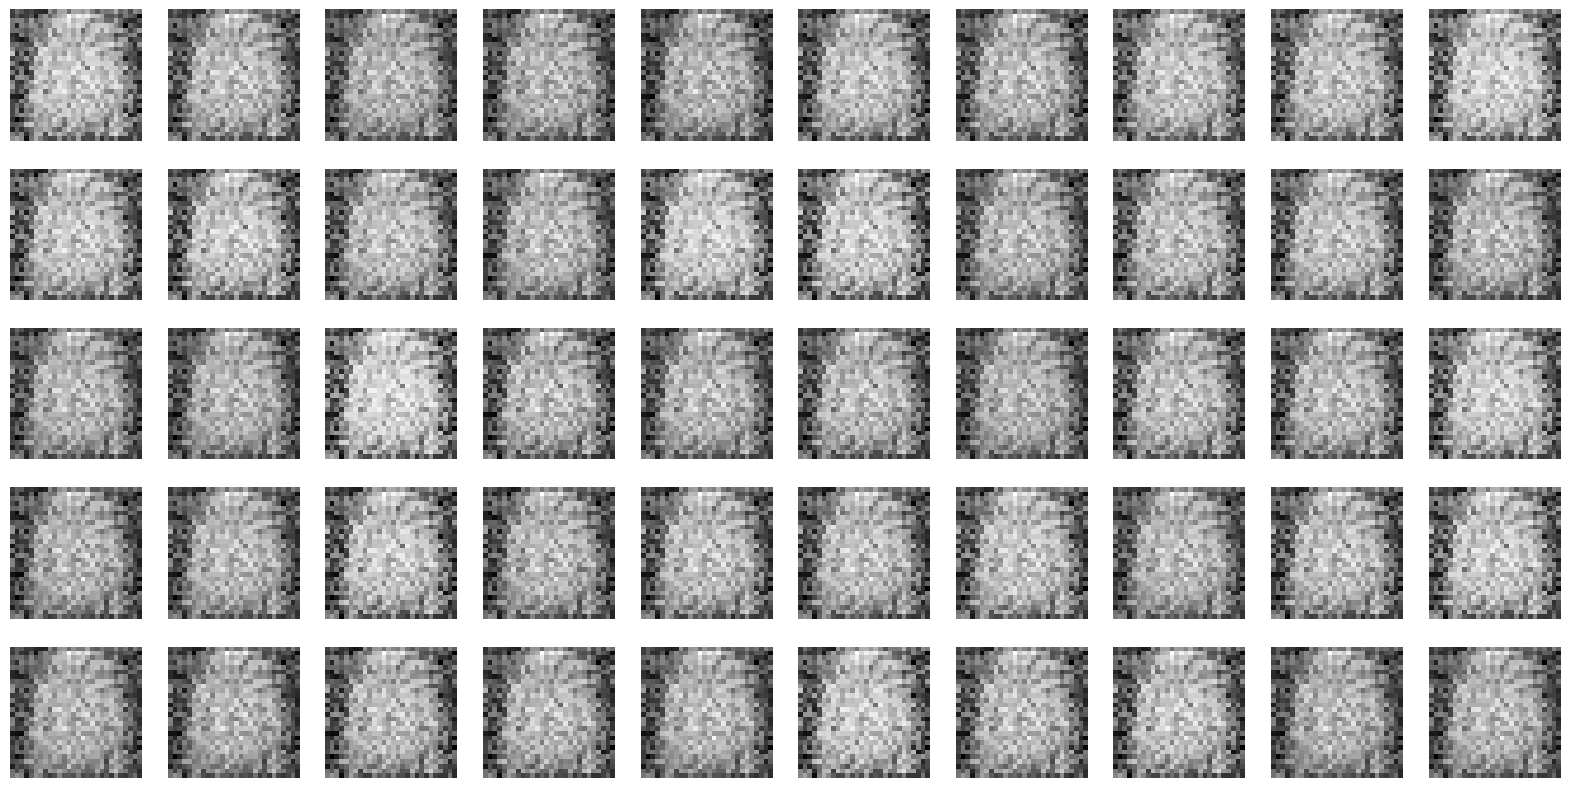

In [219]:
gnet.eval()
fake_data = gnet(torch.randn(100,64).to(device)).cpu()
fig,axs = plt.subplots(5, 10,figsize=(20,10))
for i,ax in enumerate(axs.flatten()):
    ax.imshow(fake_data[i,:,].detach().reshape(28, 28), cmap='gray')
    ax.axis('off')
plt.show()

In [220]:
losses, descDecision = trainGan(dnet, gnet, lossFun, d_optimizer, g_optimizer, 2500, loader,device)

Epoch 1/2500 | D Loss: 0.1731 | G Loss: 5.1006 | D Acc Real: 0.95 | D Acc Fake: 1.00
Epoch 2/2500 | D Loss: 0.1675 | G Loss: 5.1336 | D Acc Real: 0.95 | D Acc Fake: 1.00
Epoch 3/2500 | D Loss: 0.1672 | G Loss: 5.1510 | D Acc Real: 0.95 | D Acc Fake: 1.00
Epoch 4/2500 | D Loss: 0.1726 | G Loss: 5.0947 | D Acc Real: 0.95 | D Acc Fake: 1.00
Epoch 5/2500 | D Loss: 0.1782 | G Loss: 4.9504 | D Acc Real: 0.95 | D Acc Fake: 1.00
Epoch 6/2500 | D Loss: 0.1823 | G Loss: 4.7295 | D Acc Real: 0.95 | D Acc Fake: 1.00
Epoch 7/2500 | D Loss: 0.1794 | G Loss: 4.6241 | D Acc Real: 0.95 | D Acc Fake: 1.00
Epoch 8/2500 | D Loss: 0.1691 | G Loss: 4.6911 | D Acc Real: 0.96 | D Acc Fake: 1.00
Epoch 9/2500 | D Loss: 0.1542 | G Loss: 4.8463 | D Acc Real: 0.96 | D Acc Fake: 1.00
Epoch 10/2500 | D Loss: 0.1371 | G Loss: 5.0321 | D Acc Real: 0.96 | D Acc Fake: 1.00
Epoch 11/2500 | D Loss: 0.1214 | G Loss: 5.1655 | D Acc Real: 0.97 | D Acc Fake: 1.00
Epoch 12/2500 | D Loss: 0.1098 | G Loss: 5.2274 | D Acc Real: 0

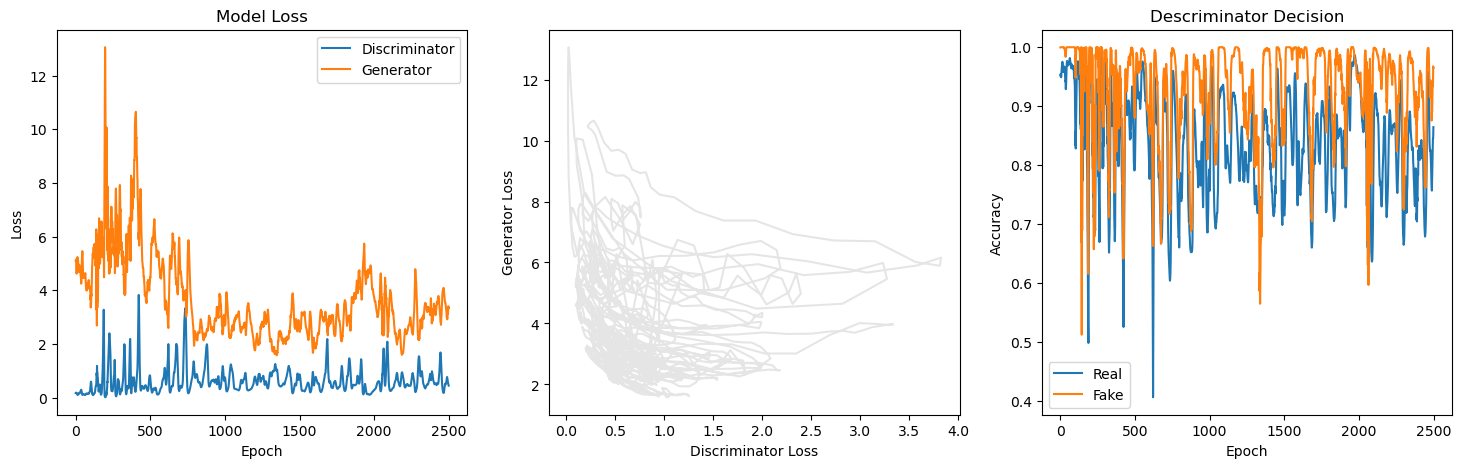

In [221]:
fig,ax = plt.subplots(1,3,figsize=(18,5))

ax[0].plot(losses)
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model Loss')
ax[0].legend(['Discriminator', 'Generator'])

ax[1].plot(losses[:,0],losses[:,1],'k',alpha=.1)
ax[1].set_xlabel('Discriminator Loss')
ax[1].set_ylabel('Generator Loss')

ax[2].plot(descDecision)
ax[2].set_xlabel('Epoch')
ax[2].set_ylabel('Accuracy')
ax[2].set_title('Descriminator Decision')
ax[2].legend(['Real', 'Fake'])

plt.show()


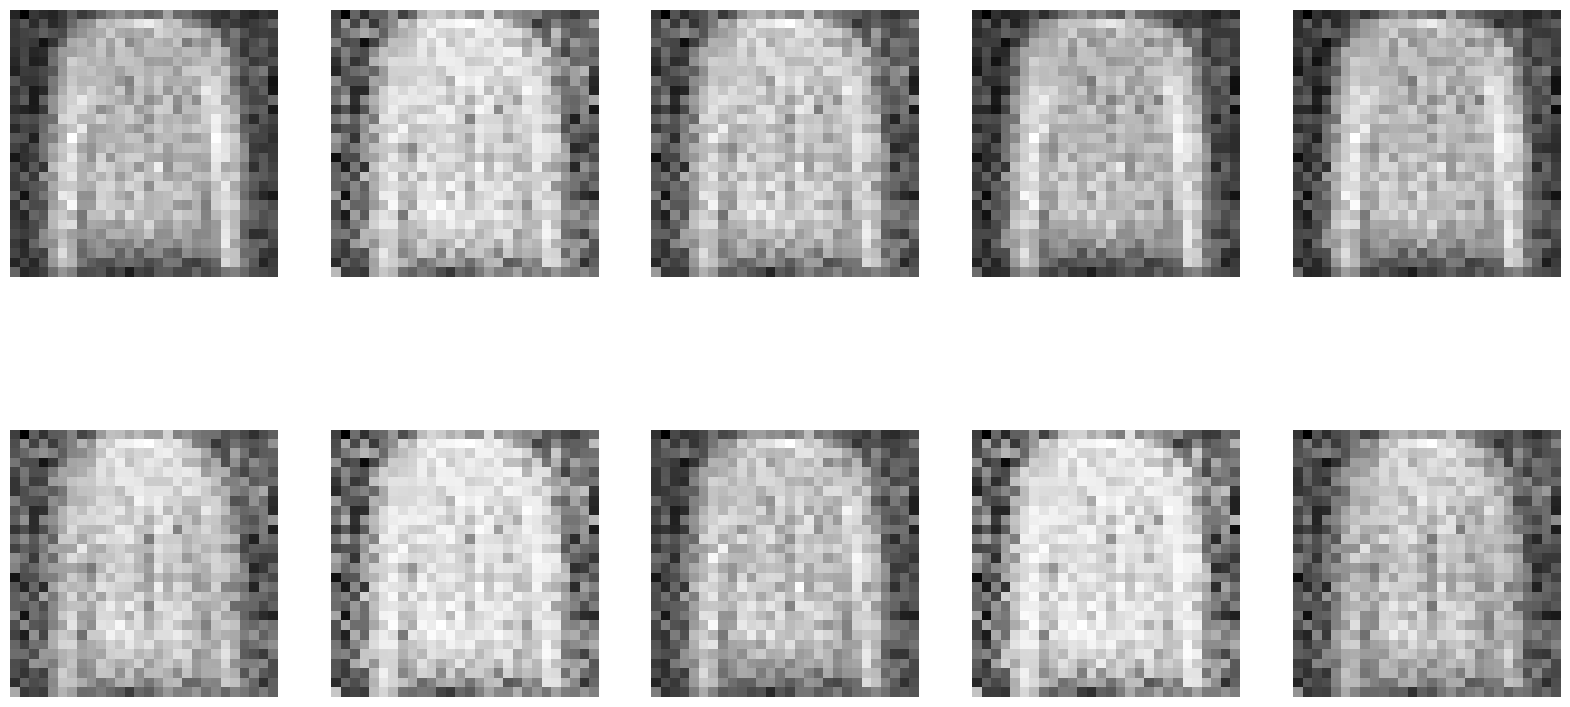

In [225]:
gnet.eval()
fake_data = gnet(torch.randn(10,64).to(device)).cpu()
fig,axs = plt.subplots(2, 5,figsize=(20,10))
for i,ax in enumerate(axs.flatten()):
    ax.imshow(fake_data[i,:,].detach().reshape(28, 28), cmap='gray')
    ax.axis('off')
plt.show()